In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
from pandas.io.json import json_normalize
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

In [2]:
# This function allows us to flatten out the columns in the pandas dataframe which are in the json format

def load_df(csv_path='../input/train.csv', JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']):
    print('Loading csv...')
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, # list of functions for each column namely json.loads 
                     dtype={'fullVisitorId': 'str','totals':'str', 'trafficSource':'str'})
    
    for column in JSON_COLUMNS:
        print(column)
        column_as_df = json_normalize(df[column].tolist())
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

def column_type(dataFrame):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:[] for object_type in type_keys }
    
    for column in dataFrame.columns:
        Dict[dataFrame[column].dtype].append(column)
    
    return Dict


def column_counts(dataFrame, threshold):
    
    type_keys = np.array(dataFrame.dtypes.unique())
    
    Dict = {object_type:{} for object_type in type_keys}
    
    for column in dataFrame.columns:
        
        if len(dataFrame[column].unique()) <= threshold:
            
            Dict[dataFrame[column].dtype][column] = len(dataFrame[column].unique())
            
    return Dict



def date_time_conversion(dataFrame, column, year = 0, month = 0, day = 0, weekday = 0, unit = None ,errors = None , format = None):
    
    dataFrame[column] = pd.to_datetime(dataFrame[column], format = format, errors = errors, unit = unit)
    
    if year: 
        dataFrame[column+'_year'] = dataFrame[column].apply(lambda x: x.year)
    
    if month:
        dataFrame[column+'_month'] = dataFrame[column].apply(lambda x: x.month)
        
    if day:
        dataFrame[column+'_day'] = dataFrame[column].apply(lambda x: x.day)
        
    if weekday:
        dataFrame[column+'_weekday'] = dataFrame[column].apply(lambda x: x.weekday())
    
    return dataFrame
        
    
    
    
    

    



In [6]:
def NaN_value_count(dataFrame):
    for column in dataFrame.columns:
        print('column name:'+str(column))
        print('number of NaN values: '+str(dataFrame[column].isnull().sum() ))
        print('percentage of NaN values: '+str(dataFrame[column].isnull().sum()/dataFrame.shape[0] ))
        print('------------')

        
def count_distribution(dataFrame,column):
    column_count = pd.Series.to_frame(dataFrame.groupby(column).size(),'count')
    column_count.reset_index(inplace = True)
    total = column_count['count'].sum()
    column_count['proportion'] = column_count['count']/total
    return column_count

In [4]:
train = pd.read_csv("data/train.csv")

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'channelGrouping', 'date',
       'fullVisitorId', 'sessionId', 'socialEngagementType', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser', 'device.browserSize',
       'device.browserVersion', 'device.deviceCategory', 'device.flashVersion',
       'device.isMobile', 'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
   

In [22]:
# Types of columns that have a total number of unique values less than a threshold
# note if we set threshold = 1 we are looking for constant columns. 

constant_column_dict = column_counts(train, threshold = 1)
constant_column_dict

{dtype('int64'): {},
 dtype('O'): {'socialEngagementType': 1,
  'device.browserSize': 1,
  'device.browserVersion': 1,
  'device.flashVersion': 1,
  'device.language': 1,
  'device.mobileDeviceBranding': 1,
  'device.mobileDeviceInfo': 1,
  'device.mobileDeviceMarketingName': 1,
  'device.mobileDeviceModel': 1,
  'device.mobileInputSelector': 1,
  'device.operatingSystemVersion': 1,
  'device.screenColors': 1,
  'device.screenResolution': 1,
  'geoNetwork.cityId': 1,
  'geoNetwork.latitude': 1,
  'geoNetwork.longitude': 1,
  'geoNetwork.networkLocation': 1,
  'trafficSource.adwordsClickInfo.criteriaParameters': 1},
 dtype('bool'): {},
 dtype('float64'): {}}

In [88]:
# Lets start by removing any constant columns 

keys = list(constant_column_dict.keys())
constant_columns = []
for type_key in keys:
    for column_key in list(constant_column_dict[type_key].keys()):
        constant_columns.append(column_key)

train = train.drop(constant_columns, axis = 1)

In [89]:
train.head()

,Unnamed: 0,Unnamed: 0.1,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.source,date_year,date_month,date_day,date_weekday,visitStartTime_year,visitStartTime_month,visitStartTime_day,visitStartTime_weekday,is_transaction
0,538448,538448,Direct,2016-08-01 00:00:00,1492602573213666603,1492602573213666603_1470044332,1470044332,1,2016-08-01 09:38:52,Chrome,...,(direct),2016,8,1,0,2016,8,1,0,0
1,538277,538277,Direct,2016-08-01 00:00:00,7394165545362887055,7394165545362887055_1470044425,1470044425,3,2016-08-01 09:40:25,Chrome,...,(direct),2016,8,1,0,2016,8,1,0,0
2,538278,538278,Referral,2016-08-01 00:00:00,6107229716178617930,6107229716178617930_1470094529,1470094529,1,2016-08-01 23:35:29,Chrome,...,mall.googleplex.com,2016,8,1,0,2016,8,1,0,0
3,538279,538279,Direct,2016-08-01 00:00:00,9459384188253198762,9459384188253198762_1470079413,1470079413,1,2016-08-01 19:23:33,Chrome,...,(direct),2016,8,1,0,2016,8,1,0,0
4,538280,538280,Direct,2016-08-01 00:00:00,4052177266351383392,4052177266351383392_1470111093,1470111093,1,2016-08-02 04:11:33,Safari,...,(direct),2016,8,1,0,2016,8,2,1,0


In [90]:
print(train.shape)
train.columns

(632557, 46)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'channelGrouping', 'date',
       'fullVisitorId', 'sessionId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'da

# Device types 

## Device browser

In [7]:
### device browser 
# most device browsers are either chrome 67% or safari 21% anything else can be encoded as OTHER

#sns.countplot(x = 'device.browser', data = train)

device_browser_info = count_distribution(train,'device.browser')
device_browser_info

,device.browser,count,proportion
0,(not set),5,0.000008
1,ADM,1,0.000002
2,Amazon Silk,396,0.000626
3,Android Browser,397,0.000628
4,Android Webview,4157,0.006572
5,Apple-iPhone7C2,3,0.000005
6,BlackBerry,142,0.000224
7,CSM Click,1,0.000002
8,Chrome,425920,0.673331
9,Coc Coc,546,0.000863


In [8]:
# lets do a group by of total transaction value by device browser

browser_transaction_values = train.groupby('device.browser').agg({'totals.transactionRevenue':{'transactionRevSum':np.sum,'transactionRevMean':np.mean},'is_transaction':{'is_transaction_sum':np.sum}     })
browser_transaction_values.reset_index(inplace = True)
browser_transaction_values.columns = browser_transaction_values.columns.droplevel(0)
browser_transaction_values['transactionRev_proportion'] = browser_transaction_values['transactionRevSum']/train['totals.transactionRevenue'].sum()
browser_transaction_values['is_transaction_proportion'] = browser_transaction_values['is_transaction_sum']/train['is_transaction'].sum()
browser_transaction_values


#pd.merge(device_browser_info,browser_transaction_values,on = 'device.browser')

###### Notes 

# can we possibly frequency encode the device browser column since clearly higher frequency tends to lead to a higher transaction revenue
# can we look at the variance of the transaction Revenue across different proportional bands.
# We expect to see an upward trend. 

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion
0,(not set),0.000000e+00,NaN,0,0.000000,0.000000
1,ADM,0.000000e+00,NaN,0,0.000000,0.000000
2,Amazon Silk,2.999000e+07,2.999000e+07,1,0.000030,0.000134
3,Android Browser,0.000000e+00,NaN,0,0.000000,0.000000
4,Android Webview,6.486000e+07,1.297200e+07,5,0.000065,0.000671
5,Apple-iPhone7C2,0.000000e+00,NaN,0,0.000000,0.000000
6,BlackBerry,0.000000e+00,NaN,0,0.000000,0.000000
7,CSM Click,0.000000e+00,NaN,0,0.000000,0.000000
8,Chrome,9.226518e+11,1.382871e+08,6672,0.917881,0.895330
9,Coc Coc,0.000000e+00,NaN,0,0.000000,0.000000


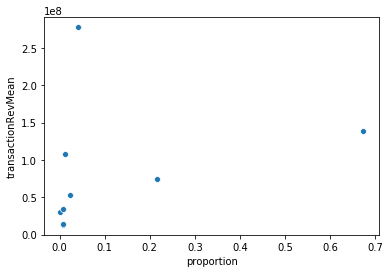

In [9]:
x = device_browser_info['proportion']
y = browser_transaction_values['transactionRevMean']
sns.scatterplot(x,y)

### Device browser report
* Clearly the plot indicates it maybe possible to use frequency encoding here especially as for a few of the browsers the number of data points which have a transaction may not be that many. 
* At the moment we are looking at $\mathbb{P}(\textbf{browser_type})$ VS $\mathbb{E}(\textbf{revenue}\; | \;\textbf{browser_type})$ thinking that the higher the probability of device type the larger the expected revenue.
* The caveat here is that there are few cases where the $\mathbb{P}(\textbf{browser_type})$ might be low but $\mathbb{E}(\textbf{revenue} | \textbf{browser_type})$ is higher. So account for this it's possible we could try the following
* One thing we might want to consider is the following $\mathbb{P}(\textbf{is_transaction} \equiv 1\;|\;\textbf{browser_type})$ VS $\mathbb{E}(\textbf{revenue}\;|\; \textbf{browser_type})$ with the expectation that this seperates categories where expected revenue is higher for certain low probability device_types. 
* So we can use  $\mathbb{P}(\textbf{is_transaction} \equiv 1 \;|\;\textbf{browser_type}) = \frac{ \mathbb{P}(\textbf{is_transaction} \equiv 1 \;\cap \;\textbf{browser_type})}{\mathbb{P}(\textbf{browser_type})} $

In [10]:
transaction_totals = train.shape[0]

# getting the required columns
browser_transaction_values = train.groupby('device.browser').agg({'totals.transactionRevenue':{'transactionRevSum':np.sum,'transactionRevMean':np.mean},'is_transaction':{'is_transaction_sum':np.sum}     })
browser_transaction_values.reset_index(inplace = True)
browser_transaction_values.columns = browser_transaction_values.columns.droplevel(0)
browser_transaction_values['transactionRev_proportion'] = browser_transaction_values['transactionRevSum']/train['totals.transactionRevenue'].sum()
browser_transaction_values['is_transaction_proportion'] = browser_transaction_values['is_transaction_sum']/train['is_transaction'].sum()
browser_transaction_values['device_browser_totals'] = device_browser_info['count']
browser_transaction_values['device_browser.probability'] = device_browser_info['proportion']
browser_transaction_values['is_transaction_and_device_probability'] = browser_transaction_values['is_transaction_sum']/transaction_totals
browser_transaction_values

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion,device_browser_totals,device_browser.probability,is_transaction_and_device_probability
0,(not set),0.000000e+00,NaN,0,0.000000,0.000000,5,0.000008,0.000000
1,ADM,0.000000e+00,NaN,0,0.000000,0.000000,1,0.000002,0.000000
2,Amazon Silk,2.999000e+07,2.999000e+07,1,0.000030,0.000134,396,0.000626,0.000002
3,Android Browser,0.000000e+00,NaN,0,0.000000,0.000000,397,0.000628,0.000000
4,Android Webview,6.486000e+07,1.297200e+07,5,0.000065,0.000671,4157,0.006572,0.000008
5,Apple-iPhone7C2,0.000000e+00,NaN,0,0.000000,0.000000,3,0.000005,0.000000
6,BlackBerry,0.000000e+00,NaN,0,0.000000,0.000000,142,0.000224,0.000000
7,CSM Click,0.000000e+00,NaN,0,0.000000,0.000000,1,0.000002,0.000000
8,Chrome,9.226518e+11,1.382871e+08,6672,0.917881,0.895330,425920,0.673331,0.010548
9,Coc Coc,0.000000e+00,NaN,0,0.000000,0.000000,546,0.000863,0.000000


In [11]:
# Adding the probability of P(is_transaction | device_browser_type)
browser_transaction_values['probability'] = browser_transaction_values['is_transaction_and_device_probability']/browser_transaction_values['device_browser.probability']
browser_transaction_values

,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion,device_browser_totals,device_browser.probability,is_transaction_and_device_probability,probability
0,(not set),0.000000e+00,NaN,0,0.000000,0.000000,5,0.000008,0.000000,0.000000
1,ADM,0.000000e+00,NaN,0,0.000000,0.000000,1,0.000002,0.000000,0.000000
2,Amazon Silk,2.999000e+07,2.999000e+07,1,0.000030,0.000134,396,0.000626,0.000002,0.002525
3,Android Browser,0.000000e+00,NaN,0,0.000000,0.000000,397,0.000628,0.000000,0.000000
4,Android Webview,6.486000e+07,1.297200e+07,5,0.000065,0.000671,4157,0.006572,0.000008,0.001203
5,Apple-iPhone7C2,0.000000e+00,NaN,0,0.000000,0.000000,3,0.000005,0.000000,0.000000
6,BlackBerry,0.000000e+00,NaN,0,0.000000,0.000000,142,0.000224,0.000000,0.000000
7,CSM Click,0.000000e+00,NaN,0,0.000000,0.000000,1,0.000002,0.000000,0.000000
8,Chrome,9.226518e+11,1.382871e+08,6672,0.917881,0.895330,425920,0.673331,0.010548,0.015665
9,Coc Coc,0.000000e+00,NaN,0,0.000000,0.000000,546,0.000863,0.000000,0.000000


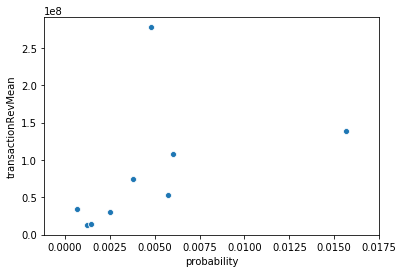

In [12]:
sns.scatterplot(x='probability',y='transactionRevMean', data = browser_transaction_values)

## Device category

In [102]:
device_category_count = count_distribution(train,'device.deviceCategory')
device_category_count

,device.deviceCategory,count,proportion
0,desktop,485293,0.767193
1,mobile,127636,0.201778
2,tablet,19628,0.031030


In [103]:
# lets do a group by of total transaction value by device category

device_category = train.groupby('device.deviceCategory').agg({'totals.transactionRevenue':{'transactionRevSum':np.sum,'transactionRevMean':np.mean},'is_transaction':{'is_transaction_sum':np.sum}     })
device_category.reset_index(inplace = True)
device_category.columns = device_category.columns.droplevel(0)
device_category['transactionRev_proportion'] = device_category['transactionRevSum']/train['totals.transactionRevenue'].sum()
device_category['is_transaction_proportion'] = device_category['is_transaction_sum']/train['is_transaction'].sum()
#browser_transaction_values
device_category

/Users/psangha/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion
0,desktop,9.642700e+11,1.420342e+08,6789,0.959284,0.911031
1,mobile,3.444365e+10,6.285338e+07,548,0.034266,0.073537
2,tablet,6.483620e+09,5.637930e+07,115,0.006450,0.015432


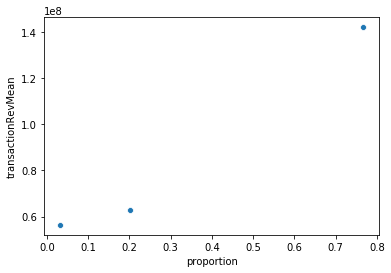

In [104]:
x = device_category_count['proportion']
y = device_category['transactionRevMean']
sns.scatterplot(x,y)

### conditional frequency encoding

In [105]:
device_category_totals = device_category_count['count'].sum()
device_category['is_transaction_device_probability'] = device_category['is_transaction_sum']/device_category_totals
device_category['device_category_probability'] = device_category_count['proportion']
device_category

,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion,is_transaction_device_probability,device_category_probability
0,desktop,9.642700e+11,1.420342e+08,6789,0.959284,0.911031,0.010733,0.767193
1,mobile,3.444365e+10,6.285338e+07,548,0.034266,0.073537,0.000866,0.201778
2,tablet,6.483620e+09,5.637930e+07,115,0.006450,0.015432,0.000182,0.031030


In [106]:
device_category['probability'] = device_category['is_transaction_device_probability']/device_category['device_category_probability']
device_category

,,transactionRevSum,transactionRevMean,is_transaction_sum,transactionRev_proportion,is_transaction_proportion,is_transaction_device_probability,device_category_probability,probability
0,desktop,9.642700e+11,1.420342e+08,6789,0.959284,0.911031,0.010733,0.767193,0.013989
1,mobile,3.444365e+10,6.285338e+07,548,0.034266,0.073537,0.000866,0.201778,0.004293
2,tablet,6.483620e+09,5.637930e+07,115,0.006450,0.015432,0.000182,0.031030,0.005859


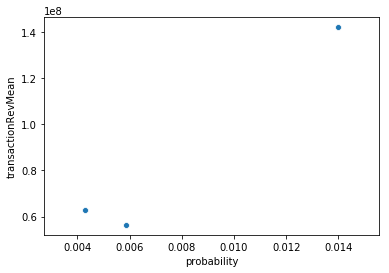

In [107]:
sns.scatterplot(x='probability',y='transactionRevMean', data = device_category)